In [1]:
%matplotlib inline

In [1]:
# 単変量LSTMでsin波予測 (チュートリアルとして規則性のあるデータを予測)

In [1]:
# データ

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# sin波生成
def sin(length=100, curve=4):
    x = np.arange(0, length)
    return np.sin((curve * np.pi) * x / length)

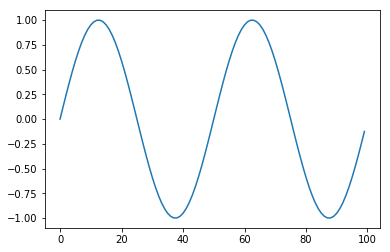

In [5]:
plt.plot(sin())
plt.show()

In [6]:
# ノイズ付きsin波
def noised_sin(length=100, curve=4, noise_rate=0.1, low=-1.0, high=1.0):
    x = sin(length=length, curve=curve)
    noise = noise_rate * np.random.uniform(low=low, high=high, size=len(x))
    return x + noise

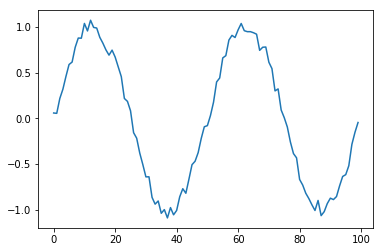

In [7]:
plt.plot(noised_sin())
plt.show()

In [8]:
# 学習用時系列データとして整形
def create_reccurent_dataset(vector_data, step=25):
    data, target = [], []
    for i in range(len(vector_data) - step):
        data.append(vector_data[i:(i + step)])
        target.append(vector_data[i + step])
    reshape_data = np.array(data).reshape(len(data), step, 1)
    reshape_label = np.array(target).reshape(len(data), 1)
    return reshape_data, reshape_label

In [9]:
# 形状と内容の確認
train_data, train_label = create_reccurent_dataset([1,2,3,4,5,6,7,8,9], 3)

In [ ]:
# 学習データ、stepで区切った時系列データ、3次元配列
# なぜ3次元なのか = 他にも気温、湿度、曜日など予測に役立ちそうなデータを入れられる。
# 今回は1個のデータのみ
# (学習データ総数, 1学習の時系列数(ステップ数), 特徴量)
print(train_data.shape)
print(train_data)

In [14]:
# 答えラベル、次に来るべき値、2次元配列
print(train_label.shape)
print(train_label)

(6, 1)
[[4]
 [5]
 [6]
 [7]
 [8]
 [9]]


In [15]:
# ノイズ付きsin波予測
data = noised_sin(length=100, curve=4, noise_rate=0.1)
train_data, train_label = create_reccurent_dataset(data, step=25)

In [24]:
train_data.shape

(75, 25, 1)

In [23]:
train_label.shape

(75, 1)

In [ ]:
# モデル構築

In [17]:
# 時系列(長短期記憶)学習モデルの種類
# RNN, LSTM, [QRNN](https://qiita.com/icoxfog417/items/d77912e10a7c60ae680e)...他
# LSTM
#   LSTM(1D) 例: 1次元の時系列データを入力として利用する
#   ConvLSTM2D 例: 動画を時系列データを入力として利用する
#   ConvLSTM3D 例: 空間の変化を時系列データを入力として利用する

In [18]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, LSTM
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping

In [19]:
step_count = 25 # 1つの学習データのStep数(今回は25)
feature_count = 1 # 特徴量 今回の学習するデータは1個のみ
hidden_unit_count = 300 # 中間層の数だと思う (公式は:出力の次元数?) https://keras.io/ja/layers/recurrent/#lstm

In [20]:
model = Sequential()
model.add(LSTM(hidden_unit_count, batch_input_shape=(None, step_count, feature_count), return_sequences=False))
model.add(Dense(1))
model.add(Activation('linear'))
optimizer = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [28]:
model.output_shape

(None, 1)

In [29]:
# 早期終了 過学習抑制、打ち切る手法 過学習(Over fitting)に陥ることを避けつつ、簡単にエポック数を考える手間を減らすことができる
# 30~50epochsくらいで十分学習できたと判断して終了するはず
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

In [30]:
# トレーニング
model.fit(
    train_data, train_label,
    batch_size=300,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Train on 67 samples, validate on 8 samples
Epoch 1/100
67/67 [==============================] - 0s - loss: 0.5605 - val_loss: 0.2132
Epoch 2/100
67/67 [==============================] - 0s - loss: 0.4432 - val_loss: 0.0928
Epoch 3/100
67/67 [==============================] - 0s - loss: 0.3542 - val_loss: 0.0402
Epoch 4/100
67/67 [==============================] - 0s - loss: 0.2866 - val_loss: 0.0375
Epoch 5/100
67/67 [==============================] - 0s - loss: 0.2293 - val_loss: 0.0464
Epoch 6/100
67/67 [==============================] - 0s - loss: 0.1736 - val_loss: 0.0397
Epoch 7/100
67/67 [==============================] - 0s - loss: 0.1194 - val_loss: 0.0191
Epoch 8/100
67/67 [==============================] - 0s - loss: 0.0731 - val_loss: 0.0043
Epoch 9/100
67/67 [==============================] - 0s - loss: 0.0416 - val_loss: 0.0181
Epoch 10/100
67/67 [==============================] - 0s - loss: 0.0321 - val_loss: 0.0571
Epoch 11/100
67/67 [==============================] - 0s

In [31]:
# 推論、検証
predictions = model.predict(train_data)

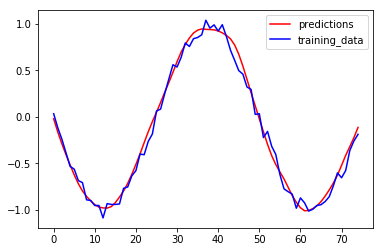

In [32]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='training_data')
plt.legend()
plt.show()

In [34]:
# 未来予測
latest_data = train_data[len(train_data)-1]
results = np.empty((0, 0))
for _ in range(50):
    # 推論
    test_data = np.reshape(latest_data, (1, 25, 1))
    batch_predict = model.predict(test_data)

    # 結果蓄積
    results = np.append(results, batch_predict)

    # 次のデータをセット
    latest_data = np.delete(latest_data, 0)
    latest_data = np.append(latest_data, batch_predict)

# (50)から(50,1)に形状を変える
results = np.reshape(results, (results.shape[0], 1))

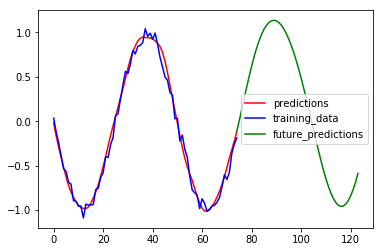

In [35]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='training_data')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results, color='g', label='future_predictions')
plt.legend()
plt.show()

In [36]:
# TODO: 多変量LSTMでアイスクリームの売り上げ予測 (売上だけではなく気温なども考慮した予測)







In [36]:
# pybitflyer データ取得

In [38]:
import pybitflyer

In [39]:
api = pybitflyer.API()
data = api.ticker(product_code='BTC_JPY')

In [42]:
data

{'best_ask': 845800.0,
 'best_ask_size': 5.8479838,
 'best_bid': 845266.0,
 'best_bid_size': 0.005,
 'ltp': 845800.0,
 'product_code': 'BTC_JPY',
 'tick_id': 1392146,
 'timestamp': '2018-03-27T09:21:59.997',
 'total_ask_depth': 4019.24505587,
 'total_bid_depth': 2823.36534775,
 'volume': 261001.28802127,
 'volume_by_product': 23999.431382}

In [43]:
print(data['ltp']) # 最終取引価格
print(data['best_ask']) # 最大売り
print(data['best_bid']) # 最大買い

845800.0
845800.0
845266.0


In [125]:
# 単変量LSTM
# まずは最終取引価格だけで最終取引価格を予測

In [46]:
import time
from datetime import datetime

In [51]:
btc_jpy_data = []
count = 5
api = pybitflyer.API()
while True:
    tick = api.ticker(product_code='BTC_JPY')
    print('tick={} ltp={}'.format(len(btc_jpy_data), tick['ltp']))
    btc_jpy_data.append(tick)
    time.sleep(1)
    if count <= len(btc_jpy_data):
        break

tick=0 ltp=847487.0
tick=1 ltp=847490.0
tick=2 ltp=847490.0
tick=3 ltp=847802.0
tick=4 ltp=847802.0


In [52]:
btc_jpy_data

[{'best_ask': 847478.0,
  'best_ask_size': 0.025,
  'best_bid': 847001.0,
  'best_bid_size': 0.03,
  'ltp': 847487.0,
  'product_code': 'BTC_JPY',
  'tick_id': 1397954,
  'timestamp': '2018-03-27T09:25:18.84',
  'total_ask_depth': 3994.4540611,
  'total_bid_depth': 2894.5315919,
  'volume': 260148.90466407,
  'volume_by_product': 23874.21524733},
 {'best_ask': 847490.0,
  'best_ask_size': 0.0079975,
  'best_bid': 847002.0,
  'best_bid_size': 0.30003,
  'ltp': 847490.0,
  'product_code': 'BTC_JPY',
  'tick_id': 1397992,
  'timestamp': '2018-03-27T09:25:19.84',
  'total_ask_depth': 3994.3422586,
  'total_bid_depth': 2907.74103526,
  'volume': 260148.23191202,
  'volume_by_product': 23872.93878457},
 {'best_ask': 847490.0,
  'best_ask_size': 0.0079975,
  'best_bid': 847012.0,
  'best_bid_size': 0.1,
  'ltp': 847490.0,
  'product_code': 'BTC_JPY',
  'tick_id': 1398025,
  'timestamp': '2018-03-27T09:25:20.747',
  'total_ask_depth': 3994.3122586,
  'total_bid_depth': 2909.29010574,
  'volume

In [82]:
# ファイルから
import json
with open('volume/datasets/BTC_JPY.json', 'r') as f:
    btc_jpy_data = json.load(f)

In [ ]:
btc_jpy_data

In [55]:
# ltpだけ利用
data = [[d['ltp']] for d in btc_jpy_data]

In [ ]:
data

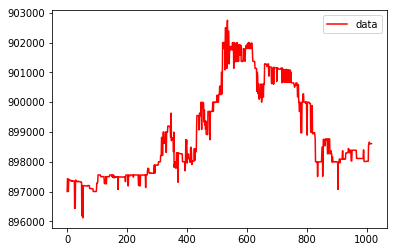

In [57]:
plt.figure()
plt.plot(range(0, len(data)), data, color='r', label='data')
plt.legend()
plt.show()

In [59]:
# 標準化
# すべての値を0~1の範囲に納める
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(data)
print(normalized_data)

[[ 0.13355442]
 [ 0.19882424]
 [ 0.19882424]
 ..., 
 [ 0.37564064]
 [ 0.37564064]
 [ 0.37564064]]


In [60]:
train_data, train_label = create_reccurent_dataset(normalized_data, step=5)
print(train_data.shape)
print(train_label.shape)

(1012, 5, 1)
(1012, 1)


In [61]:
# モデル構築
step_count = 5
feature_count = 1
hidden_unit_count = 300
model = Sequential()
model.add(LSTM(hidden_unit_count, batch_input_shape=(None, step_count, feature_count), return_sequences=False))
model.add(Dense(1))
model.add(Activation('linear'))
optimizer = Adam(lr=0.00001) # 学習率 0.001 -> 0.003 -> 0.03 -> 0.01
model.compile(loss='mean_squared_error', optimizer=optimizer)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=0)

In [ ]:
# トレーニング
model.fit(
    train_data, train_label,
    batch_size=2000,
    epochs=200,
    validation_split=0.1,
    callbacks=[early_stopping]
)

In [69]:
model.predict(np.array([[[1.0],[0.8],[0.6],[0.4],[0.2]]]))[0][0]

0.16381782

In [70]:
model.predict(np.array([[[0.0],[0.0],[0.0],[0.0],[0.0]]]))[0][0]

0.033030827

In [71]:
model.predict(np.array([[[1.0],[1.0],[1.0],[1.0],[1.0]]]))[0][0]

0.22467513

In [72]:
model.predict(np.array([[[0.2],[0.4],[0.6],[0.8],[1.0]]]))[0][0]

0.12799616

In [77]:
# 推論、検証
predictions = model.predict(train_data)

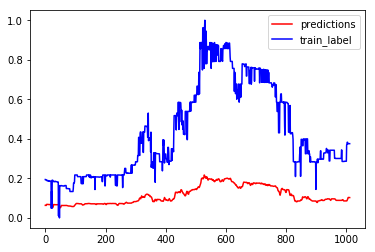

In [78]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='train_label')
plt.legend()
plt.show()

In [79]:
# 未来予測
latest_data = train_data[len(train_data)-1]
results = np.empty((0, 0))
for _ in range(50):
    # 推論
    test_data = np.reshape(latest_data, (1, 5, 1))
    batch_predict = model.predict(test_data)
    # 結果蓄積
    results = np.append(results, batch_predict)
    # 次のデータをセット
    latest_data = np.delete(latest_data, 0)
    latest_data = np.append(latest_data, batch_predict)

# (個数)から(個数,1)に形状を変える
results = np.reshape(results, (results.shape[0], 1))

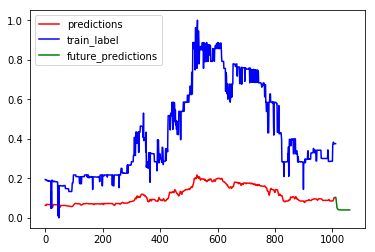

In [76]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='train_label')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results, color='g', label='future_predictions')
plt.legend()
plt.show()

In [81]:
# 多特徴のLSTM 利用する特徴 ltp, best_ask, best_bid

In [83]:
ltp_data = np.array([[d['ltp']] for d in btc_jpy_data])
best_ask_data = np.array([[d['best_ask']] for d in btc_jpy_data])
best_bid_data = np.array([[d['best_bid']] for d in btc_jpy_data])

In [85]:
# 標準化
scaler = MinMaxScaler(feature_range=(0, 1))
ltp_data = scaler.fit_transform(ltp_data)
best_ask_data = scaler.fit_transform(best_ask_data)
best_bid_data = scaler.fit_transform(best_bid_data)

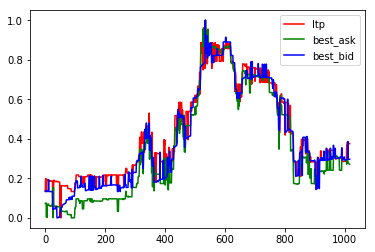

In [86]:
plt.figure()
plt.plot(range(0, len(ltp_data)), ltp_data, color='r', label='ltp')
plt.plot(range(0, len(best_ask_data)), best_ask_data, color='g', label='best_ask')
plt.plot(range(0, len(best_bid_data)), best_bid_data, color='b', label='best_bid')
plt.legend()
plt.show()

In [87]:
ltp_train_data, ltp_train_label = create_reccurent_dataset(ltp_data, step=5)
best_ask_train_data, best_ask_train_label = create_reccurent_dataset(best_ask_data, step=5)
best_bid_train_data, best_bid_train_label = create_reccurent_dataset(best_bid_data, step=5)

In [88]:
print(ltp_train_data.shape)
print(best_ask_train_data.shape)
print(best_bid_train_data.shape)

(1012, 5, 1)
(1012, 5, 1)
(1012, 5, 1)


In [89]:
print(ltp_train_label.shape)
print(best_ask_train_label.shape)
print(best_bid_train_label.shape)

(1012, 1)
(1012, 1)
(1012, 1)


In [91]:
# 推論する際の形状 = (個数, ステップ数, 特徴量)
# 前回の推論時の形状 = (個数, 5, 1)
# 今回の推論時の形状 = (個数, 5, 3)
# 入力も出力もltp, best_ask, best_bidの3つ
train_data = np.c_[ltp_train_data, best_ask_train_data, best_bid_train_data]
train_label = np.c_[ltp_train_label, best_ask_train_label, best_bid_train_label]
print(train_data.shape)
print(train_label.shape)

(1012, 5, 3)
(1012, 3)


In [92]:
# モデル構築
step_count = 5
feature_count = 3
hidden_unit_count = 300

model = Sequential()
model.add(LSTM(hidden_unit_count, batch_input_shape=(None, step_count, feature_count), return_sequences=False))
model.add(Dense(3))
model.add(Activation('linear'))
optimizer = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

In [ ]:
# トレーニング
model.fit(
    train_data, train_label,
    batch_size=2000,
    epochs=200,
    validation_split=0.1,
    callbacks=[early_stopping]
)

In [94]:
# 推論、検証
predictions = model.predict(train_data)

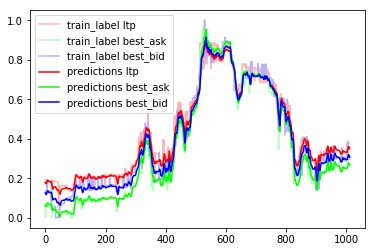

In [95]:
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,0], color=(1.0, 0.7, 0.7), label='train_label ltp')
plt.plot(range(0, len(train_label)), train_label[:,1], color=(0.7, 1.0, 0.7), label='train_label best_ask')
plt.plot(range(0, len(train_label)), train_label[:,2], color=(0.7, 0.7, 1.0), label='train_label best_bid')
plt.plot(range(0, len(predictions)), predictions[:,0], color=(1.0, 0.0, 0.0), label='predictions ltp')
plt.plot(range(0, len(predictions)), predictions[:,1], color=(0.0, 1.0, 0.0), label='predictions best_ask')
plt.plot(range(0, len(predictions)), predictions[:,2], color=(0.0, 0.0, 1.0), label='predictions best_bid')
plt.legend()
plt.show()

In [118]:
latest_data = np.array([train_data[len(train_data)-1]])
results = []
for _ in range(50):
    # 推論
    batch_predict = model.predict(latest_data)
    # 結果蓄積
    results.append([batch_predict[0][0], batch_predict[0][1], batch_predict[0][2]])
    # 次のデータをセット
    latest_data = np.delete(latest_data, np.array([batch_predict]), axis=1)
    latest_data = np.append(latest_data, np.array([batch_predict]), axis=1)
results = np.array(results)
results.shape

/Users/t01530/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


(50, 3)

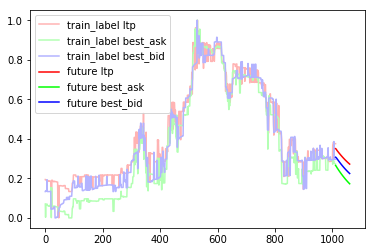

In [123]:
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,0], color=(1.0, 0.7, 0.7), label='train_label ltp')
plt.plot(range(0, len(train_label)), train_label[:,1], color=(0.7, 1.0, 0.7), label='train_label best_ask')
plt.plot(range(0, len(train_label)), train_label[:,2], color=(0.7, 0.7, 1.0), label='train_label best_bid')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,0], color=(1.0, 0.0, 0.0), label='future ltp')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,1], color=(0.0, 1.0, 0.0), label='future best_ask')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,2], color=(0.0, 0.0, 1.0), label='future best_bid')
plt.legend()
plt.show()

In [124]:
# TODO: リアルタイム予測 and 学習
# 特徴量を増やすと良いかもしれない 最大、最小、ローソク足の最大最小、関連ニュース数(良し悪し別)、曜日

In [127]:
# TODO: RNN  word2vec